# Correlation Networks analysis per band

In [1]:
from lrgsglib.core import *
from lrgsglib.config.funcs import bandpass_sos
#
cwd = Path.cwd()
while cwd.name != 'lrg_eegfc':
    %cd ..
    cwd = Path.cwd()
#
from src.lrg_eegfc.core import *
#
data_path = Path('data')
fig_path = data_path / Path('figures')
mat_path = Path('data') / 'stereoeeg_patients'
patients_list = [p.name for p in Path(mat_path).iterdir() 
                 if p.is_dir() and p.name.startswith('Pat_')]
#
phase_labels = ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
param_keys_list = ['fs', 'fcutHigh', 'fcutLow', 'filter_order', 'NotchFilter', 'DataDimensions']

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


## Input Data

### Data import

In [2]:
data_dict = {}
int_label_pos_map = {}

for pat in patients_list:
    data_dict[pat] = {}
    #
    patnum = int(pat.split('_')[-1])
    patpath = mat_path / pat
    #
    ch_dat = pd.read_csv(patpath / f'Implant_pat_{patnum}.csv')
    ch_names = pd.read_csv(patpath / 'channel_labels.csv')
    #
    int_label_pos_map[pat] = ch_names.merge(ch_dat,on='label', how='left')
    df = int_label_pos_map[pat][['x', 'y', 'z']]
    df = df.apply(lambda s: s.str.replace(',', '.', regex=False).astype(float))
    #
    for phase in phase_labels:
        data_dict[pat][phase] = {}
        try:
            # Load the .mat file using scipy.io.loadmat
            # This is the preferred method for loading .mat files
            tmp_mat = loadmat(str(mat_path / pat / f'{phase}'))
        except Exception as e:
            # If loading fails, fall back to h5py
            print(f'{type(e).__name__} loading {pat} {phase}: {e}. ',
                  f'Continuing with h5py', end='\r', flush=True)
            tmp_mat = {}
            f = h5py.File(mat_path / pat / f'{phase}.mat')
            for k, v in f.items():
                tmp_mat[k] = np.array(v)
            pass
        data_dict[pat][phase]['data'] = tmp_mat['Data']
        tmp_shape = data_dict[pat][phase]['data'].shape
        if tmp_shape[0] > tmp_shape[1]:
            # Transpose the data if the first dimension is bigger
            data_dict[pat][phase]['data'] = data_dict[pat][phase]['data'].T
        try:
            # Extract the parameters from the loaded data
            # Check if 'Parameters' is in the loaded data
            # If not, skip to the next iteration
            for param in tmp_mat['Parameters'].dtype.names:
                if param in param_keys_list:
                    data_dict[pat][phase][param] = tmp_mat['Parameters'][param][0][0][0][0]
        except:
            print(f'No parameters found for {pat} {phase}', end='\r', flush=True)
            continue

### Test on a specific Patient-Phase dataset

In [18]:
patient = 'Pat_02'
phase = 'rsPre'
filttime = 80

In [19]:
data_Pat_rsPre = data_dict[patient][phase]['data'][:, :filttime]
C = np.corrcoef(data_Pat_rsPre)
C_clean, eigvals_C, eigvecs_C, lambda_min, lambda_max, sm = clean_correlation_matrix(data_Pat_rsPre)

In [20]:
n_channels, time_steps = data_Pat_rsPre.shape
gamma = time_steps/n_channels
lambda_min = (1 - np.sqrt(1/gamma))**2
lambda_max = (1 + np.sqrt(1/gamma))**2
#
counts, bins = np.histogram(eigvals_C, density=True, bins=500)
counts2, bins2 = np.histogram(np.linalg.eigvals(C_clean), density=True, bins=1000)
MP_dist = marchenko_pastur(bins, gamma)

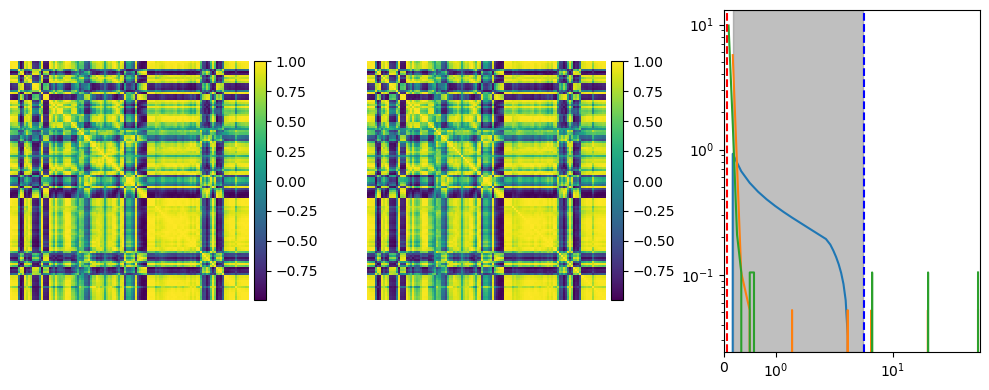

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
#
vmin = min(C.min(), C_clean.min())
vmax = max(C.max(), C_clean.max())
#
kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=vmin, vmax=vmax)
im = ax[0].imshow(C, **kwargs_imshow)
div, cax, clb = imshow_colorbar_caxdivider(im, ax[0])
im = ax[1].imshow(C_clean, **kwargs_imshow)
div, cax, clb = imshow_colorbar_caxdivider(im, ax[1])

ax[0].axis('off')
ax[1].axis('off')

ax[2].plot(bins, MP_dist, label='Marchenko-Pastur')
ax[2].plot(bins[1:], counts, label='Empirical')
ax[2].plot(bins2[1:], counts2, label='Cleaned')
ax[2].axvline(x=lambda_min, color='red', linestyle='--', label='lambda_min')
ax[2].axvline(x=lambda_max, color='blue', linestyle='--', label='lambda_max')
ax[2].fill_between(bins, 0, 1, where=(bins > lambda_min) & (bins < lambda_max), color='gray', alpha=0.5, transform=ax[2].get_xaxis_transform())
ax[2].set_yscale('log')
ax[2].set_xscale('symlog')
ax[2].set_xlim(left=0);

fig.tight_layout()
fig.savefig(fig_path / f'{patient}_{phase}_corrnet_bands.png', dpi=300, bbox_inches='tight')

## Correlation Network

### Building the network by thresholding

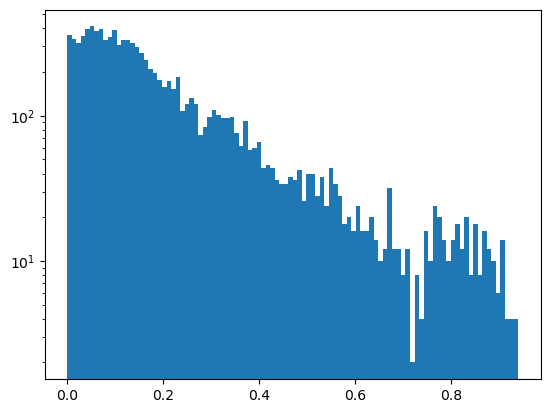

In [27]:
C_net = C_clean.copy()
C_net[C_net < 0] = 0
# C_net = np.abs(C_net)
np.fill_diagonal(C_net, 0)
arr = C_net.copy().flatten()
arr = arr[arr != 0]
plt.hist(arr, bins=100)
plt.yscale('log')
G = nx.from_numpy_array(C_net)

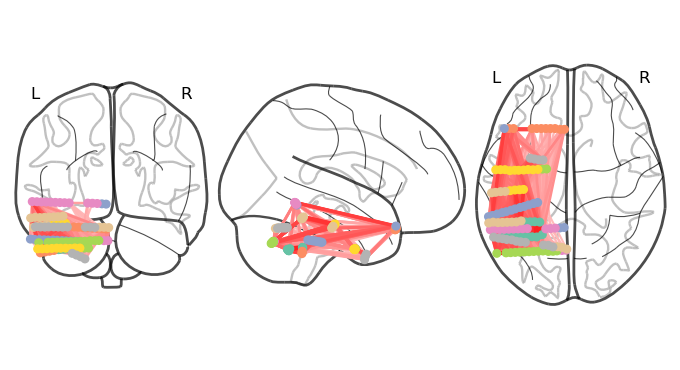

In [19]:
A = C_net          # adjacency matrix
from nilearn import plotting          # <-- add this
# --- plotting -------------------------------------------------------
plotting.plot_connectome(
    adjacency_matrix=A,
    node_coords=int_label_pos_map[pat][['x', 'y', 'z']].replace(',', '.', regex=True).astype(float).to_numpy(),
    node_size=30,
    edge_threshold="80%"        # draw strongest 20 % of edges; adjust as needed
)
plotting.show()

In [28]:
Th, Einf, Pinf = compute_threshold_stats(G)
Pinf_diff = np.diff(Pinf)
jumps = np.where(Pinf_diff != 0)[0]

Computing threshold stats: 100%|██████████| 117/117 [00:01<00:00, 58.74it/s]


In [29]:
not_in_giant = {}
for i,jump in enumerate(jumps):
    C_tmp = C_net.copy()
    C_tmp[C_tmp < Th[jump]*1.1] = 0
    G = nx.from_numpy_array(C_tmp)
    Gcc = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(Gcc)
    # get the nodes not in the giant component
    not_in_giant[i] = set(G.nodes()) - set(Gcc.nodes())
    if i > 0:
        not_in_giant[i] = not_in_giant[i]-not_in_giant[i-1]

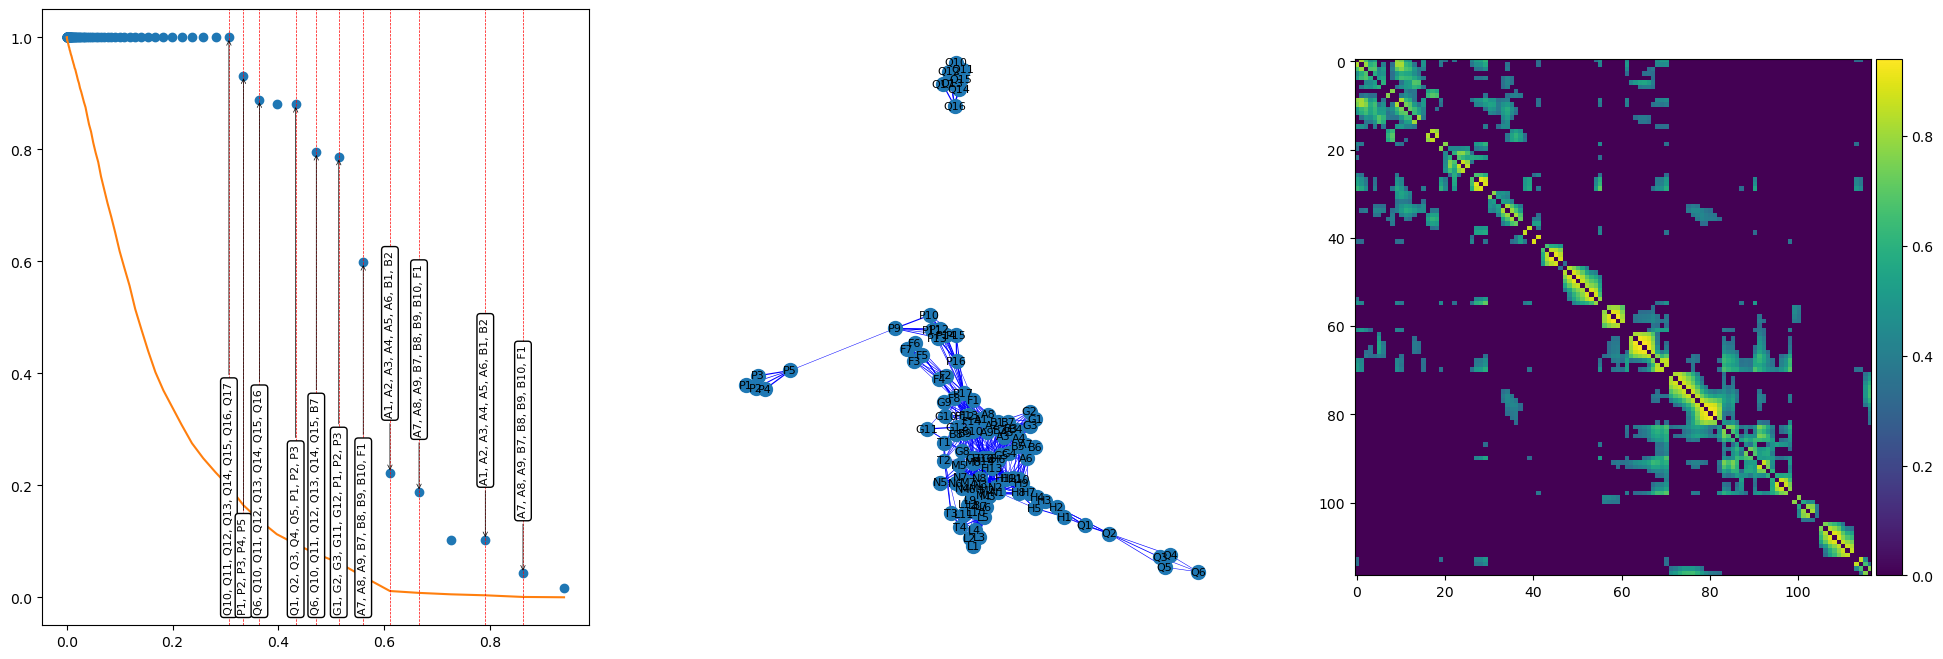

In [31]:
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
#
ax[0].plot(Th, Pinf, 'o')
ax[0].plot(Th, Einf)
for i,jump in enumerate(jumps):
    ax[0].axvline(Th[jump], color='r', linestyle='--', lw=0.5)
    #annotate the vertical line with the names of the nodes not in the giant component
    #create a string with the names of the nodes not in the giant component and rotate 90 the text in annotate
    not_in_giant_str = ', '.join([int_label_pos_map[pat]['label'][n] for n in not_in_giant[i]][:8])
    ax[0].annotate(not_in_giant_str, xy=(Th[jump], Pinf[jump]),
                xytext=(Th[jump], Pinf[jump]+0.1 if Pinf[jump] < 0.5 else -0.03),
                rotation=90,
                fontsize=8,
                ha='center',
                va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'),
                arrowprops=dict(arrowstyle="->", lw=0.5, color='black'))
#
C_tmp = C_net.copy()
C_tmp[C_tmp < Th[jumps[1]]] = 0
G = nx.from_numpy_array(C_tmp)
widths = [ G[u][v]['weight'] for u, v in G.edges()]
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G.edges(data=True)]
nx.draw(G, ax=ax[1], node_size=100, width=widths, edge_color=edge_colors, with_labels=True, labels=int_label_pos_map[pat]['label'],font_size=8)
#
kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=C_tmp.min(), vmax=C_tmp.max())
im = ax[2].imshow(C_tmp, **kwargs_imshow)
div, cax, clb = imshow_colorbar_caxdivider(im, ax[2])

### Building the correlation network by band

In [13]:
sample_rate = 2048
filter_order = 4
corr_nets = {}
corr_graphs = {}
for band_name, (low, high) in BRAIN_BANDS.items():
    # 4a) filter all channels at once
    filt = bandpass_sos(data_Pat_rsPre, low, high, sample_rate, filter_order)
    C_filt = np.abs(np.corrcoef(filt))
    np.fill_diagonal(C_filt, 0)
    corr_nets[band_name] = C_filt
    corr_graphs[band_name] = nx.from_numpy_array(C_filt)

Computing threshold stats: 100%|██████████| 100/100 [00:02<00:00, 45.34it/s]


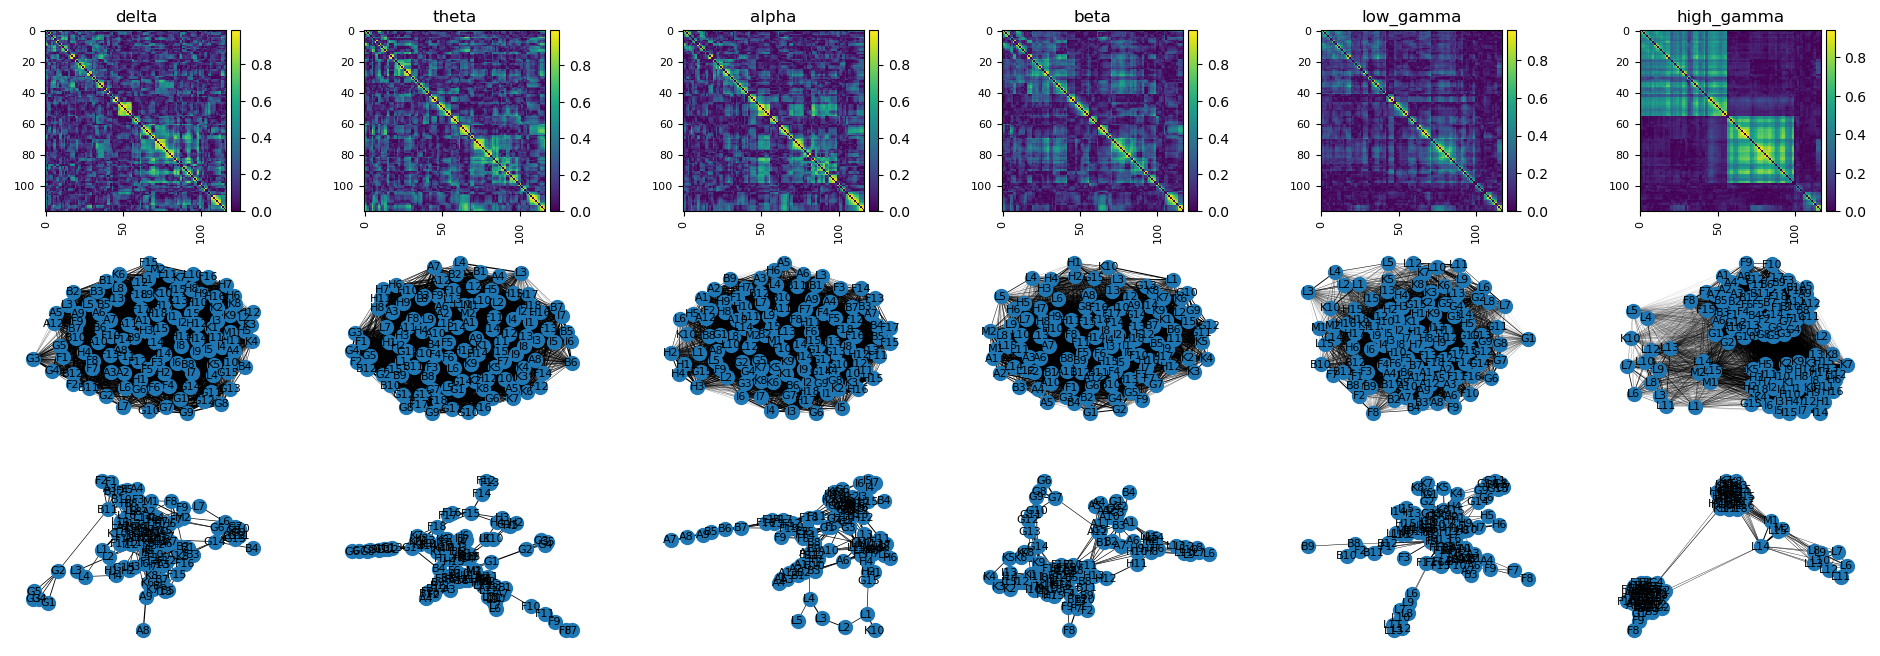

In [17]:
corr_graphs_filt = {}
corr_nets_filt = {}

fig, ax = plt.subplots(3, len(BRAIN_BANDS), figsize=(24, 8))
for i, (band_name, C_filt) in enumerate(corr_nets.items()):
    G = corr_graphs[band_name]
    Th, Einf, Pinf = compute_threshold_stats(G, n_points=100)
    Pinf_diff = np.diff(Pinf)
    jumps = np.where(Pinf_diff != 0)[0]
    C_tmp = C_filt.copy()
    C_tmp[C_tmp < Th[jumps[1]]] = 0
    G = nx.from_numpy_array(C_tmp)
    corr_nets_filt[band_name] = C_tmp
    corr_graphs_filt[band_name] = G
    Gcc = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(Gcc)
    widths = [ Gcc[u][v]['weight'] for u, v in Gcc.edges()]
    nx.draw(Gcc, ax=ax[2][i], node_size=100, width=widths,  with_labels=True, labels={k: ch_int_name_map['Pat_02'][k] for k in list(Gcc.nodes())},font_size=8)
for i, (band_name, C_filt) in enumerate(corr_nets.items()):
    kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=C_filt.min(), vmax=C_filt.max())
    im = ax[0][i].imshow(C_filt, **kwargs_imshow)
    div, cax, clb = imshow_colorbar_caxdivider(im, ax[0][i])
    ax[0][i].set_title(band_name)
    for tick in ax[0][i].get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(8)
        tick.set_color('black')
    for tick in ax[0][i].get_yticklabels():
        tick.set_fontsize(8)
        tick.set_color('black')
for i, (band_name, C_filt) in enumerate(corr_nets.items()):
    G = corr_graphs[band_name]
    widths = [ G[u][v]['weight'] for u, v in G.edges()]
    nx.draw(G, width=widths, ax=ax[1][i], node_size=100, with_labels=True, labels=ch_int_name_map['Pat_02'],font_size=8)

### One band Analysis

In [18]:
oneband = 'beta'
GG = corr_graphs_filt[oneband]
GG = get_giant_component(GG)
CC = corr_nets_filt[oneband]

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


KeyError: 0

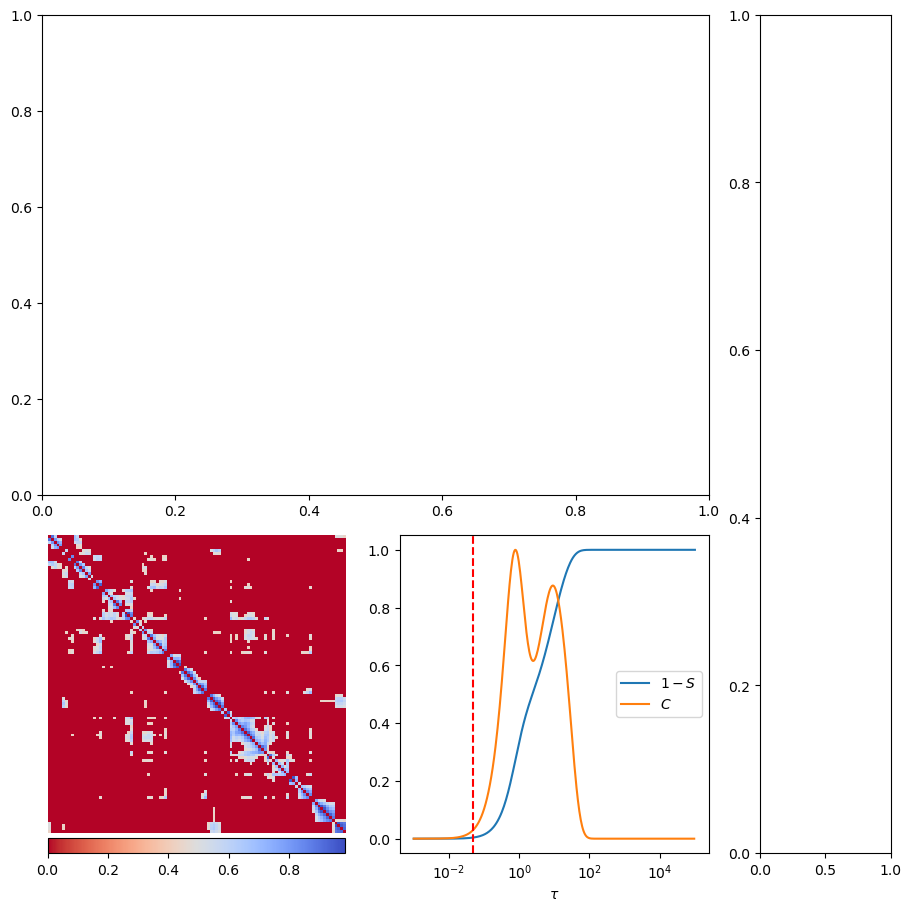

In [19]:
plot_graph_analysis(GG, ch_int_name_map)

### Check of the Correspondence in bands from Pre/Post task tails

In [20]:
n_patient = 2
patient = f'Pat_0{n_patient}'
phasePre = 'taskLearn'
phasePost = 'taskTest'
band = 'high_gamma'
filttimePre = len(data_dict[patient][phasePre]['data'][0])//10
filttimePost = len(data_dict[patient][phasePost]['data'][0])//10

In [21]:
i = 0
i1 = 9
Pat_rsPre = data_dict[patient][phasePre]['data'][:, i*filttimePre:(i+1)*filttimePre]
Pat_rsPost = data_dict[patient][phasePost]['data'][:, i1*filttimePost:(i1+1)*filttimePost-1]

Pat_rsPre_filt = bandpass_sos(Pat_rsPre, BRAIN_BANDS[band][0], BRAIN_BANDS[band][1], sample_rate, filter_order)
Pat_rsPost_filt = bandpass_sos(Pat_rsPost, BRAIN_BANDS[band][0], BRAIN_BANDS[band][1], sample_rate, filter_order)

#### code runner

In [22]:
CPre = np.corrcoef(Pat_rsPre_filt)
CPre_clean, eigvals_C1, eigvecs_C1, lambda_min1, lambda_max1, sm1 = clean_correlation_matrix(Pat_rsPre_filt)
CPre_clean[CPre_clean < 0] = 0
np.fill_diagonal(CPre_clean, 0)
#
CPost = np.corrcoef(Pat_rsPost_filt)
CPost_clean, eigvals_C2, eigvecs_C2, lambda_min2, lambda_max2, sm2 = clean_correlation_matrix(Pat_rsPost_filt)
CPost_clean[CPost_clean < 0] = 0
np.fill_diagonal(CPost_clean, 0)

In [23]:
GPre = nx.from_numpy_array(CPre_clean)
Th, Einf, Pinf = compute_threshold_stats(GPre, n_points=100)
Pinf_diff = np.diff(Pinf)
jumps = np.where(Pinf_diff != 0)[0]
CPre_eff = CPre_clean.copy()
CPre_eff[CPre_eff < Th[jumps[0]]] = 0
#
GPost = nx.from_numpy_array(CPost_clean)
Th, Einf, Pinf = compute_threshold_stats(GPost, n_points=100)
Pinf_diff = np.diff(Pinf)
jumps = np.where(Pinf_diff != 0)[0]
CPost_eff = CPost_clean.copy()
CPost_eff[CPost_eff < Th[jumps[0]]] = 0

Computing threshold stats: 100%|██████████| 100/100 [00:01<00:00, 83.94it/s]


In [24]:
GPre = nx.from_numpy_array(CPre_eff)
# GPre = get_giant_component(GPre)
#
GPost = nx.from_numpy_array(CPost_eff)
# GPost = get_giant_component(GPost)

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


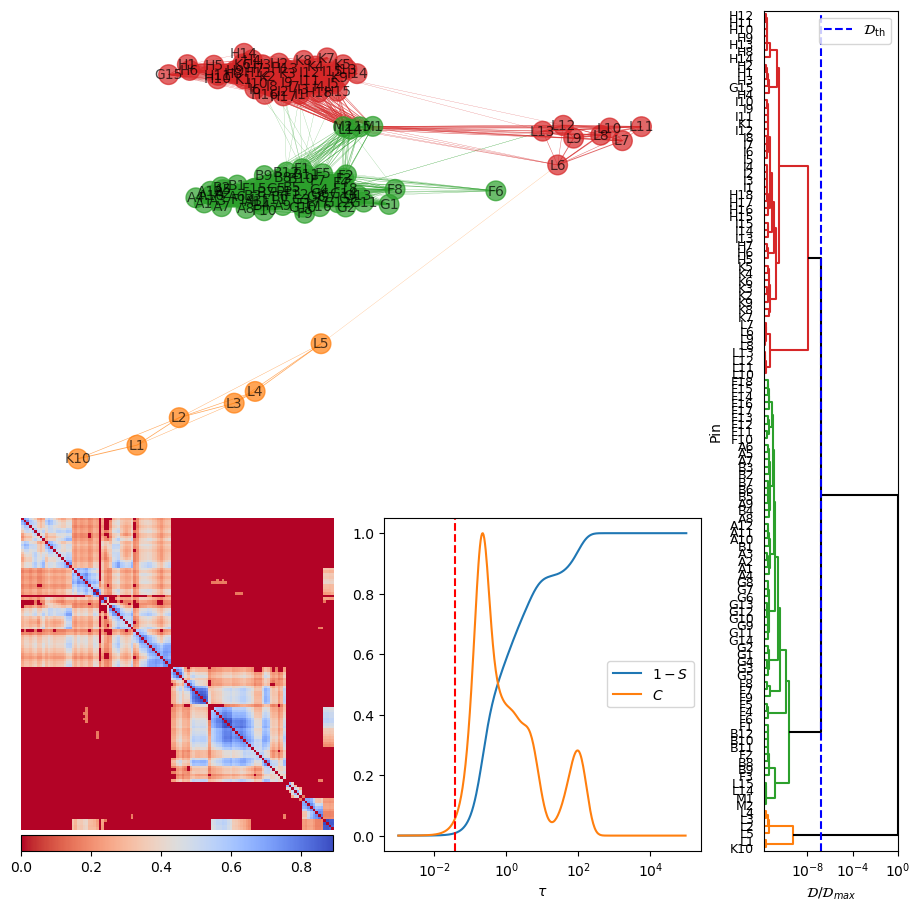

In [26]:
figPre, _ = plot_graph_analysis(GPre, ch_int_name_map['Pat_02'])
figPre.savefig(fig_path / ('_'.join([patient, band, phasePre, f't={i}'])+'.pdf'),  bbox_inches='tight')

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (2, 3)

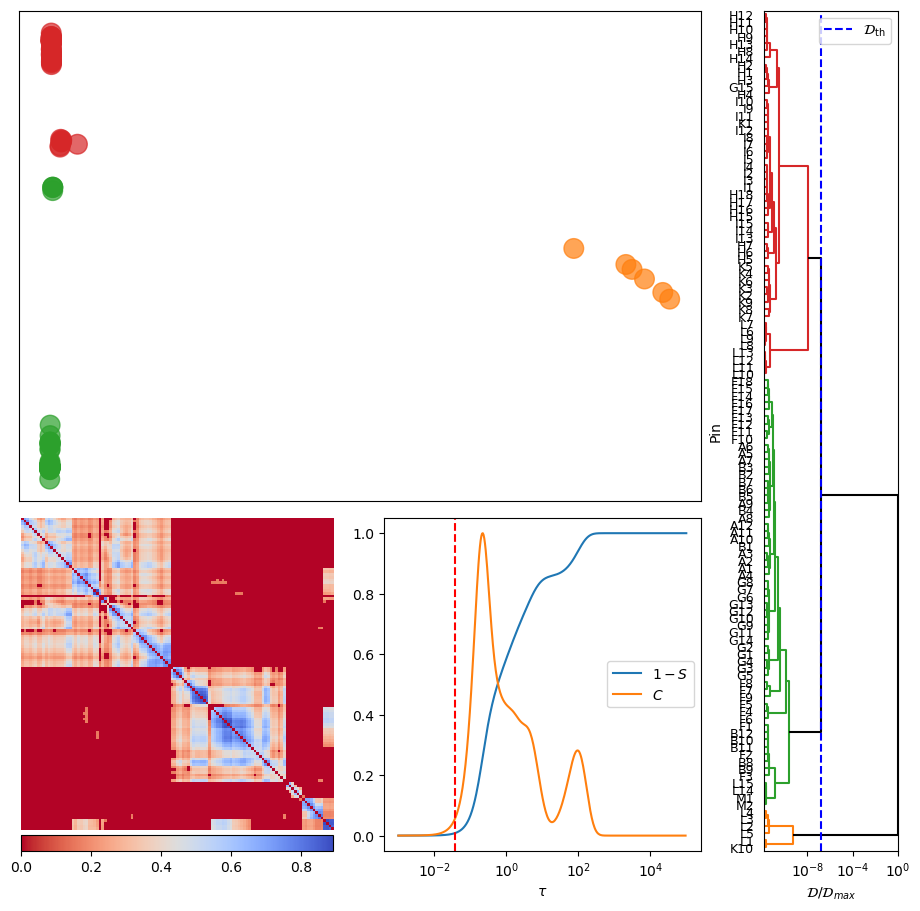

In [ ]:
def plot_graph_analysis(
    GG,
    ch_int_name_map,
    *,
    t1=-3,
    t2=5,
    steps=400,
    linkage_method='ward',
    entropy_func=entropy,
    laplacian_func=compute_laplacian_properties,
    linkage_func=compute_normalized_linkage,
):
    """
    Parameters
    ----------
    GG : networkx.Graph
        Weighted graph.
    ch_int_name_map : dict
        Node → label mapping used throughout plots.
    Returns
    -------
    fig : matplotlib.figure.Figure
    optimal_clusters : ndarray
        Cluster assignment for each node.
    """
    # adjacency matrix
    CC = nx.to_numpy_array(GG, weight='weight')
    GGtmp = GG.copy()
    GG= get_giant_component(GGtmp)
    # network entropy
    net_ent = entropy_func(GG, t1=t1, t2=t2, steps=steps)
    tau_scale = net_ent[-1]
    speC = net_ent[1] / net_ent[1].max()
    Sm1 = net_ent[0] / net_ent[0].max()

    # laplacian-based distances
    spectrum, L, rho, Trho, tau = laplacian_func(GG, tau=None)
    dists = squareform(Trho)
    linkage_matrix, label_list, _ = linkage_func(dists, GG, method=linkage_method)
    FlatClusteringTh, *_ = compute_optimal_threshold(linkage_matrix)
    optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')

    # figure layout
    fig = plt.figure(constrained_layout=True, figsize=(9, 9))
    ax = fig.subplot_mosaic(
        """
        DDDDE
        DDDDE
        DDDDE
        BBCCE
        BBCCE
        """
    )

    # adjacency matrix
    im = ax['B'].imshow(CC, cmap='coolwarm_r', interpolation='none')
    imshow_colorbar_caxdivider(im, ax['B'], position='bottom', orientation='horizontal')
    ax['B'].axis('off')

    # entropy curves
    ax['C'].plot(tau_scale, Sm1, label=r'$1-S$')
    ax['C'].plot(tau_scale[:-1], speC, label=r'$C$')
    ax['C'].set_xscale('log')
    ax['C'].legend()
    ax['C'].set_xlabel(r'$\tau$')
    ax['C'].axvline(tau, color='r', linestyle='--')

    # dendrogram
    relabel_list = [ch_int_name_map[n] for n in label_list]
    dendro = dendrogram(
        linkage_matrix,
        ax=ax['E'],
        color_threshold=FlatClusteringTh,
        above_threshold_color='k',
        leaf_font_size=9,
        labels=relabel_list,
        orientation='right',
    )
    tmin = linkage_matrix[:, 2][0] * 0.8
    tmax = linkage_matrix[:, 2][-1] * 1.1
    ax['E'].axvline(FlatClusteringTh, color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
    ax['E'].set_xscale('log')
    ax['E'].set_xlim(tmin, tmax)
    ax['E'].legend()
    ax['E'].set_xlabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
    ax['E'].set_ylabel('Pin')

    # graph with cluster colors
    leaf_label_colors = {
        lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])
    }
    node_colors = [leaf_label_colors[ch_int_name_map[n]] if n in GG.nodes() else 'k' for n in GGtmp.nodes()]
    widths = [GGtmp[u][v].get('weight', 1.0) for u, v in GGtmp.edges()]
    edge_colors = [leaf_label_colors[ch_int_name_map[u]] if u in GG.nodes() else 'k' for u, v in GGtmp.edges()]

    pos = nx.spectral_layout(GGtmp)
    LL = nx.laplacian_matrix(GGtmp)
    eigv, eighV = scsp_eigsh(LL, k=4, which='SM')
    eighV = np.array(eighV / np.linalg.norm(eighV))


    nx.draw(
        GGtmp,
        pos=pos,
        ax=ax['D'],
        node_size=200,
        font_size=10,
        width=widths,
        edge_color=edge_colors,
        node_color=node_colors,
        alpha=0.7,
        with_labels=True,
        labels=ch_int_name_map,
    )

    return fig, optimal_clusters

figPre, _ = plot_graph_analysis(GPre, ch_int_name_map['Pat_02'])


In [ ]:
LL = nx.laplacian_matrix(GPost)
eigv, eighV = scsp_eigsh(LL, k=4, which='SM')
eighV = eighV.T
eighV2 = np.array([i / np.linalg.norm(i) for i in eighV.T/eighV[0][0]])

In [52]:
ch_pos_list['Pat_02']

array([[-20.528, -53.975, -41.97 ],
       [-24.797, -55.764, -42.496],
       [-28.29 , -55.616, -42.656],
       [-31.783, -55.469, -42.815],
       [-35.276, -55.321, -42.974],
       [-38.77 , -55.173, -43.134],
       [-42.263, -55.026, -43.293],
       [-45.756, -54.878, -43.452],
       [-49.249, -54.73 , -43.612],
       [-52.743, -54.583, -43.771],
       [-56.236, -54.435, -43.931],
       [-59.729, -54.287, -44.09 ],
       [-22.448, -44.489, -41.105],
       [-26.257, -44.207, -40.954],
       [-29.705, -44.283, -41.554],
       [-33.152, -44.358, -42.153],
       [-36.6  , -44.433, -42.753],
       [-40.047, -44.508, -43.352],
       [-43.495, -44.584, -43.952],
       [-46.942, -44.659, -44.552],
       [-50.389, -44.734, -45.151],
       [-53.837, -44.809, -45.751],
       [-57.284, -44.885, -46.35 ],
       [-60.732, -44.96 , -46.95 ],
       [ -3.739,  25.771, -27.726],
       [ -6.936,  25.727, -27.508],
       [-10.892,  26.379, -27.244],
       [-14.385,  26.379, -2

In [56]:
x, y, z = ch_pos_list['Pat_02'].T

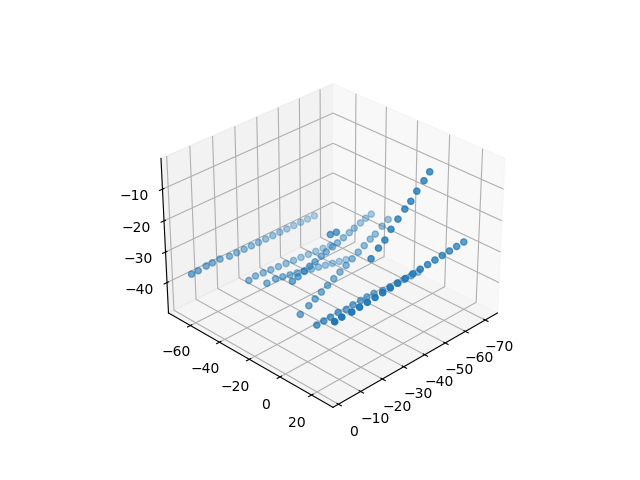

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.view_init(azim=45, elev=30)

plt.show()

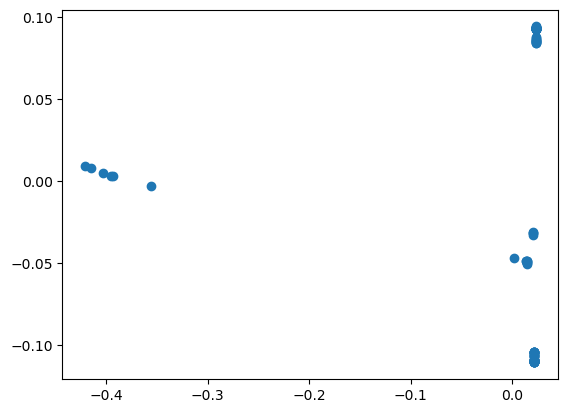

In [ ]:
plt.scatter(x=eighV2[1], y=eighV2[2], z=eighV2[3])

In [45]:
[eighV / np.linalg.norm(eighV) for i in eighV]

[array([[ 0.04622502,  0.01147268,  0.04685566, -0.00137177],
        [ 0.04622502,  0.01147054,  0.04675712, -0.00136439],
        [ 0.04622502,  0.01147084,  0.04677083, -0.00136541],
        [ 0.04622502,  0.01147252,  0.04684797, -0.00137118],
        [ 0.04622502,  0.01147013,  0.04673835, -0.00136298],
        [ 0.04622502,  0.01146877,  0.04667602, -0.00135836],
        [ 0.04622502,  0.01147156,  0.0468039 , -0.00136789],
        [ 0.04622502,  0.01147095,  0.04677588, -0.00136578],
        [ 0.04622502,  0.01146858,  0.04666732, -0.00135772],
        [ 0.04622502,  0.0114696 ,  0.04671435, -0.00136125],
        [ 0.04622502,  0.01146788,  0.04663519, -0.00135536],
        [ 0.04622502,  0.01146899,  0.04668604, -0.00135913],
        [ 0.04622502,  0.01147045,  0.04675333, -0.00136414],
        [ 0.04622502,  0.0114692 ,  0.04669566, -0.00135984],
        [ 0.04622502,  0.01146914,  0.04669302, -0.00135964],
        [ 0.04622502,  0.01146956,  0.04671209, -0.00136105],
        

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


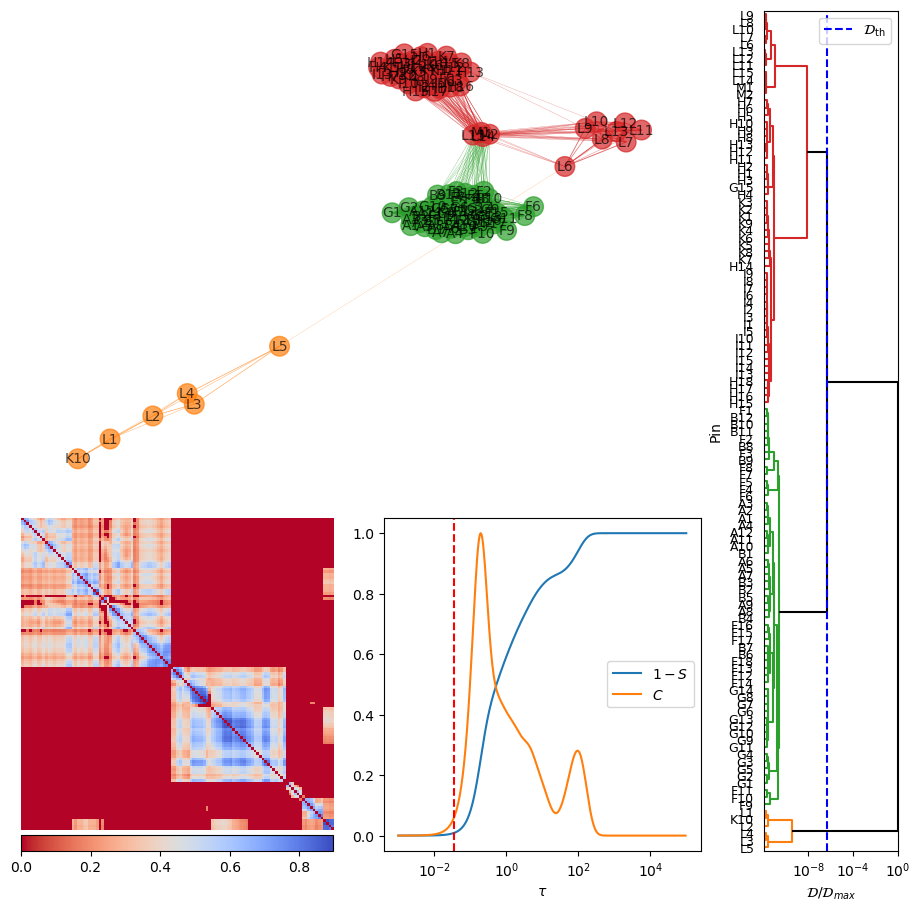

In [27]:
figPost, _ = plot_graph_analysis(GPost, ch_int_name_map['Pat_02'])
figPost.savefig(fig_path / ('_'.join([patient, band, phasePost, f't={i1}'])+'.pdf'),  bbox_inches='tight')